# Basic Neural Network Modifications and Their Effects

## This a set of tests to see how changing a simple neural network affects its accuracy, loss, and training time. The tests are based on an example in section 3.4 of Francois Chollet's book *Deep Learning with Python* and its recommendations for experiments

In [1]:
import numpy as np

from keras.datasets import imdb
from keras import models, layers

import matplotlib.pyplot as plt

from timeit import default_timer

Using TensorFlow backend.


In [2]:
number_of_examples = 9
number_of_tests = 5

training_times = np.zeros((number_of_examples, number_of_tests))
test_accuracies = np.zeros((number_of_examples, number_of_tests))

example_number = 0

For the purpose of these tests, we will be using a dataset of IMDB reviews. We will check to see how many words in each review matches a list of 10,000 words. We will then try to determine a correlation between the words used in a review and whether the review was positive or negative.

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The following function will take an array reviews and return a matrix that breaks down each review into a 10,000 element vector of ones and zeros depending on whether corresponding words were used in each review.

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [5]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

To start with, let's set aside some of the training reviews to be used exclusively for testing the model's accuracy on fresh data during training.

In [6]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

The following function creates a basic feed forward neural network and returns a dictionary with information about the training and testing of the neural network. We will use this to test how changing things around affect training time and results.

In [7]:
def create_train_and_evaluate_model(epoch_quantity=4,
                                    layer_quantity=2, 
                                    node_quantity=16,
                                    loss_function='binary_crossentropy',
                                    activation_function='relu'):
    
    return_dict = dict()
    
    model = models.Sequential()
    model.add(layers.Dense(node_quantity, activation=activation_function, input_shape=(10000,)))
    
    for i in range(layer_quantity - 1):
        model.add(layers.Dense(node_quantity, activation=activation_function))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss=loss_function, metrics=['accuracy'])
    
    return_dict['time'] = default_timer()
    return_dict['history'] = model.fit(partial_x_train, partial_y_train, epochs=epoch_quantity, batch_size=512, validation_data=(x_val, y_val))
    return_dict['time'] = default_timer() - return_dict['time']
    
    return_dict['loss'], return_dict['accuracy'] = model.evaluate(x_test, y_test)
    
    return return_dict

To get things running, we will start with a neural network with two hidden layers consisting of the following elements:

### Example 1
* number of epochs = 20
* number of hidden layers = 2 
* nodes per hidden layer = 16
* loss function = binary crossentropy
* activation function = rectified linear unit

In [8]:
returned_dict = create_train_and_evaluate_model(epoch_quantity=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 6s 396us/step - loss: 0.4976 - acc: 0.7953 - val_loss: 0.3717 - val_acc: 0.8721
Epoch 2/20
15000/15000 [==============================] - 4s 276us/step - loss: 0.2957 - acc: 0.9047 - val_loss: 0.2990 - val_acc: 0.8910
Epoch 3/20
15000/15000 [==============================] - 4s 263us/step - loss: 0.2160 - acc: 0.9287 - val_loss: 0.3089 - val_acc: 0.8713
Epoch 4/20
15000/15000 [==============================] - 4s 264us/step - loss: 0.1742 - acc: 0.9433 - val_loss: 0.2831 - val_acc: 0.8839
Epoch 5/20
15000/15000 [==============================] - 4s 275us/step - loss: 0.1414 - acc: 0.9543 - val_loss: 0.2863 - val_acc: 0.8851
Epoch 6/20
15000/15000 [==============================] - 4s 272us/step - loss: 0.1143 - acc: 0.9654 - val_loss: 0.3088 - val_acc: 0.8809
Ep

Now that we've thuroughly trainined our first neural network, let's check to see the loss values after each epoch.

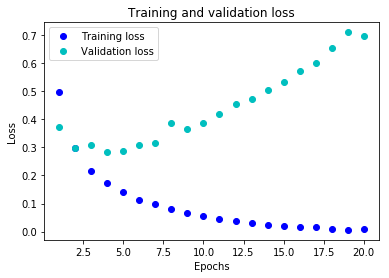

In [9]:
history_dict = returned_dict['history'].history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'co', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The training loss dropped after each epoch, but the validation loss started to increase after the fourth epoch. This is a bit counter intuitive, as one might think that more training would yield better results. Let's check the accuracies to see if anything similar happened.

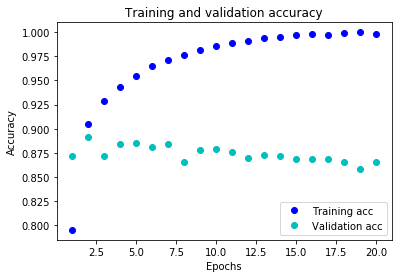

In [10]:
plt.clf()

val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'co', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

It appears that, like our loss, our validation accuracy gets worse after the first few test while the training accuracy continues to improve. It starts off strong. However, while the training accuracy continues to improve, the validation accuracy starts to drop off after the fourth epoch.

This is because of a problem called overfitting. We trained our neural network based on the training data we gave it. Because we gave it the same data over and over again, it became very good at predicting the results from that data, but it also specialized in that data. As specialization increased, the network's ability to generalize decreased. Decreased generalization means that our network was more easily fooled by new data.

It looks like things started getting worse after the fourth epoch, so for the rest of our examples, we will only use four epochs.

To make things easier to see at once, for the rest of the examples, we will plot our losses and accuracies on the same plot. The following function does just that and gives our test accuracy, test loss, and training time.

In [11]:
def graph_loss_and_accuracy(training_data):
    
    print('Loss: ' + str(round(training_data['loss'],4)) + '\nAccuracy: ' + str(round(training_data['accuracy'],4)) + '\nTraining time: ' 
          + str(round(training_data['time'],4)))
    
    history_dict = training_data['history'].history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    epochs = range(1, len(acc_values) + 1)

    plt.clf()
    
    plt.plot(epochs, loss_values, 'ro', label='Training loss')
    plt.plot(epochs, val_loss_values, 'ms', label='Validation loss')
    plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'cs', label='Validation accuracy')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss or Accuracy')
    plt.legend()

    plt.show()

Loss: 0.7706
Accuracy: 0.8508
Training time: 83.0271


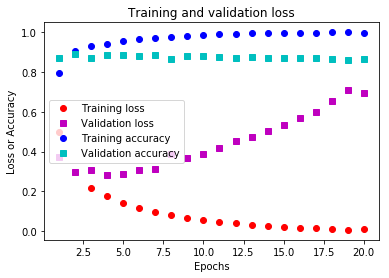

In [12]:
test_accuracies[example_number, 0] = returned_dict['accuracy'] 
training_times[example_number, 0] = returned_dict['time']
example_number += 1
graph_loss_and_accuracy(returned_dict)

As the above imformation shows, our accuracy could be improved, and our loss leaves plenty of room to be desired. Let's see how things look after only four epochs. For later comparison, we will train each model five times to get a more robust average. Running this more times would be nice, but my laptop can only do so much before being overwhelmed. 

Training and evaluating the following examples will be pretty cut and dry, so I advise skipping down to the analysis. I'll plot the results of the last training run for each example and give breif information if you do want to exmine each example more closely.

### Example 2
* number of epochs = 4
* number of hidden layers = 2 
* nodes per hidden layer = 16
* loss function = binary crossentropy
* activation function = rectified linear unit

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 5s 348us/step - loss: 0.5326 - acc: 0.7917 - val_loss: 0.4063 - val_acc: 0.8700
Epoch 2/4
15000/15000 [==============================] - 4s 268us/step - loss: 0.3258 - acc: 0.8989 - val_loss: 0.3153 - val_acc: 0.8852
Epoch 3/4
15000/15000 [==============================] - 5s 314us/step - loss: 0.2357 - acc: 0.9245 - val_loss: 0.2827 - val_acc: 0.8898
Epoch 4/4
25000/25000 [==============================] - 6s 246us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 5s 363us/step - loss: 0.5013 - acc: 0.7921 - val_loss: 0.3705 - val_acc: 0.8698
Epoch 2/4
15000/15000 [==============================] - 4s 296us/step - loss: 0.2950 - acc: 0.8999 - val_loss: 0.3000 - val_acc: 0.8861
Epoch 3/4
15000/15000 [==============================] - 4s 284us/step - loss: 0.2149 - acc: 0.9300 - val_loss: 0.2818 - val_acc: 0.8882
Epoch 4

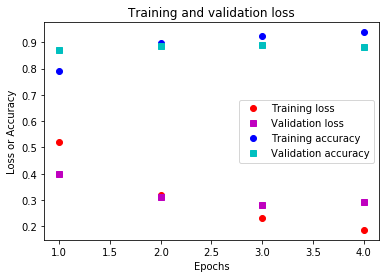

In [13]:
for test_number in range(number_of_tests):
    returned_dict = create_train_and_evaluate_model()
    test_accuracies[example_number, test_number] = returned_dict['accuracy'] 
    training_times[example_number, test_number] = returned_dict['time']

example_number += 1
graph_loss_and_accuracy(returned_dict)

### Example 3
* number of epochs = 4
* **number of hidden layers = 1**
* nodes per hidden layer = 16
* loss function = binary crossentropy
* activation function = rectified linear unit

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 5s 340us/step - loss: 0.5005 - acc: 0.7999 - val_loss: 0.3908 - val_acc: 0.8659
Epoch 2/4
15000/15000 [==============================] - 4s 266us/step - loss: 0.3198 - acc: 0.9026 - val_loss: 0.3207 - val_acc: 0.8855
Epoch 3/4
15000/15000 [==============================] - 4s 277us/step - loss: 0.2478 - acc: 0.9235 - val_loss: 0.2958 - val_acc: 0.8878
Epoch 4/4
25000/25000 [==============================] - 5s 204us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 5s 336us/step - loss: 0.4884 - acc: 0.7979 - val_loss: 0.3805 - val_acc: 0.8737
Epoch 2/4
15000/15000 [==============================] - 4s 274us/step - loss: 0.3098 - acc: 0.9045 - val_loss: 0.3276 - val_acc: 0.8742
Epoch 3/4
15000/15000 [==============================] - 4s 276us/step - loss: 0.2404 - acc: 0.9251 - val_loss: 0.3007 - val_acc: 0.8801
Epoch 4

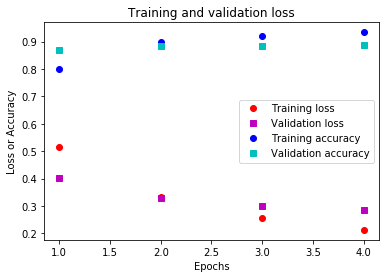

In [14]:
for test_number in range(number_of_tests):
    returned_dict = create_train_and_evaluate_model(layer_quantity=1)
    test_accuracies[example_number, test_number] = returned_dict['accuracy'] 
    training_times[example_number, test_number] = returned_dict['time']

example_number += 1
graph_loss_and_accuracy(returned_dict)

### Example 4
* number of epochs = 4
* **number of hidden layers = 3**
* nodes per hidden layer = 16
* loss function = binary crossentropy
* activation function = rectified linear unit

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 6s 371us/step - loss: 0.5270 - acc: 0.7747 - val_loss: 0.3931 - val_acc: 0.8630
Epoch 2/4
15000/15000 [==============================] - 5s 330us/step - loss: 0.2950 - acc: 0.9036 - val_loss: 0.3256 - val_acc: 0.8690
Epoch 3/4
15000/15000 [==============================] - 5s 315us/step - loss: 0.2069 - acc: 0.9303 - val_loss: 0.2736 - val_acc: 0.8911
Epoch 4/4
25000/25000 [==============================] - 6s 235us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 6s 381us/step - loss: 0.5322 - acc: 0.7720 - val_loss: 0.3926 - val_acc: 0.8634
Epoch 2/4
15000/15000 [==============================] - 4s 273us/step - loss: 0.3036 - acc: 0.9031 - val_loss: 0.3318 - val_acc: 0.8647
Epoch 3/4
15000/15000 [==============================] - 4s 276us/step - loss: 0.2175 - acc: 0.9269 - val_loss: 0.2800 - val_acc: 0.8891
Epoch 4

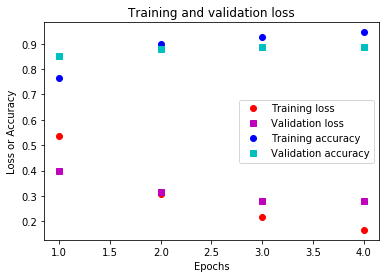

In [15]:
for test_number in range(number_of_tests):
    returned_dict = create_train_and_evaluate_model(layer_quantity=3)
    test_accuracies[example_number, test_number] = returned_dict['accuracy'] 
    training_times[example_number, test_number] = returned_dict['time']

example_number += 1
graph_loss_and_accuracy(returned_dict)

### Example 5
* number of epochs = 4
* number of hidden layers = 1
* **nodes per hidden layer = 32**
* loss function = binary crossentropy
* activation function = rectified linear unit

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 436us/step - loss: 0.5010 - acc: 0.7800 - val_loss: 0.3736 - val_acc: 0.8611
Epoch 2/4
15000/15000 [==============================] - 4s 293us/step - loss: 0.2820 - acc: 0.9057 - val_loss: 0.2887 - val_acc: 0.8872
Epoch 3/4
15000/15000 [==============================] - 4s 297us/step - loss: 0.2020 - acc: 0.9295 - val_loss: 0.2744 - val_acc: 0.8897
Epoch 4/4
25000/25000 [==============================] - 7s 281us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 478us/step - loss: 0.5019 - acc: 0.7823 - val_loss: 0.4336 - val_acc: 0.8022
Epoch 2/4
15000/15000 [==============================] - 5s 303us/step - loss: 0.2844 - acc: 0.9043 - val_loss: 0.3032 - val_acc: 0.8818
Epoch 3/4
15000/15000 [==============================] - 5s 302us/step - loss: 0.1987 - acc: 0.9306 - val_loss: 0.2759 - val_acc: 0.8895
Epoch 4

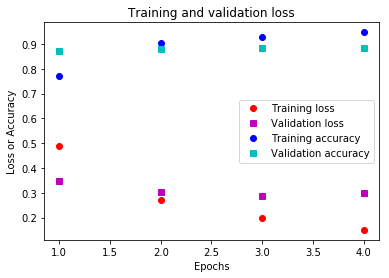

In [16]:
for test_number in range(number_of_tests):
    returned_dict = create_train_and_evaluate_model(node_quantity=32)
    test_accuracies[example_number, test_number] = returned_dict['accuracy'] 
    training_times[example_number, test_number] = returned_dict['time']

example_number += 1
graph_loss_and_accuracy(returned_dict)

### Example 6
* number of epochs = 4
* number of hidden layers = 1
* **nodes per hidden layer = 64**
* loss function = binary crossentropy
* activation function = rectified linear unit

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 8s 544us/step - loss: 0.4841 - acc: 0.7694 - val_loss: 0.3237 - val_acc: 0.8812
Epoch 2/4
15000/15000 [==============================] - 6s 379us/step - loss: 0.2695 - acc: 0.9020 - val_loss: 0.3322 - val_acc: 0.8611
Epoch 3/4
15000/15000 [==============================] - 5s 328us/step - loss: 0.1818 - acc: 0.9351 - val_loss: 0.2755 - val_acc: 0.8884
Epoch 4/4
25000/25000 [==============================] - 8s 308us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 8s 531us/step - loss: 0.4818 - acc: 0.7668 - val_loss: 0.3306 - val_acc: 0.8764
Epoch 2/4
15000/15000 [==============================] - 5s 346us/step - loss: 0.2582 - acc: 0.9045 - val_loss: 0.4325 - val_acc: 0.8175
Epoch 3/4
15000/15000 [==============================] - 5s 319us/step - loss: 0.1874 - acc: 0.9319 - val_loss: 0.2771 - val_acc: 0.8898
Epoch 4

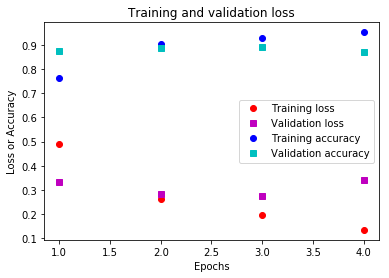

In [17]:
for test_number in range(number_of_tests):
    returned_dict = create_train_and_evaluate_model(node_quantity=64)
    test_accuracies[example_number, test_number] = returned_dict['accuracy'] 
    training_times[example_number, test_number] = returned_dict['time']

example_number += 1
graph_loss_and_accuracy(returned_dict)

### Example 7
* number of epochs = 4
* number of hidden layers = 1
* **nodes per hidden layer = 8**
* loss function = binary crossentropy
* activation function = rectified linear unit

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 6s 407us/step - loss: 0.5650 - acc: 0.7627 - val_loss: 0.4684 - val_acc: 0.8595
Epoch 2/4
15000/15000 [==============================] - 4s 260us/step - loss: 0.3858 - acc: 0.8939 - val_loss: 0.3617 - val_acc: 0.8861
Epoch 3/4
15000/15000 [==============================] - 4s 257us/step - loss: 0.2842 - acc: 0.9238 - val_loss: 0.3166 - val_acc: 0.8871
Epoch 4/4
25000/25000 [==============================] - 6s 225us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 434us/step - loss: 0.5602 - acc: 0.7771 - val_loss: 0.4611 - val_acc: 0.8652
Epoch 2/4
15000/15000 [==============================] - 4s 266us/step - loss: 0.3795 - acc: 0.8931 - val_loss: 0.3592 - val_acc: 0.8836
Epoch 3/4
15000/15000 [==============================] - 4s 270us/step - loss: 0.2848 - acc: 0.9158 - val_loss: 0.3100 - val_acc: 0.8878
Epoch 4

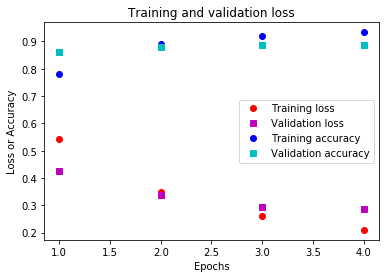

In [18]:
for test_number in range(number_of_tests):
    returned_dict = create_train_and_evaluate_model(node_quantity=8)
    test_accuracies[example_number, test_number] = returned_dict['accuracy'] 
    training_times[example_number, test_number] = returned_dict['time']

example_number += 1
graph_loss_and_accuracy(returned_dict)

### Example 8
* number of epochs = 4
* number of hidden layers = 1
* nodes per hidden layer = 32
* **loss function = mean squared error**
* activation function = rectified linear unit

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 483us/step - loss: 0.1710 - acc: 0.7815 - val_loss: 0.1162 - val_acc: 0.8745
Epoch 2/4
15000/15000 [==============================] - 4s 274us/step - loss: 0.0890 - acc: 0.9058 - val_loss: 0.0921 - val_acc: 0.8891
Epoch 3/4
15000/15000 [==============================] - 4s 264us/step - loss: 0.0650 - acc: 0.9281 - val_loss: 0.0865 - val_acc: 0.8878
Epoch 4/4
25000/25000 [==============================] - 6s 233us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 442us/step - loss: 0.1689 - acc: 0.7890 - val_loss: 0.1166 - val_acc: 0.8776
Epoch 2/4
15000/15000 [==============================] - 4s 268us/step - loss: 0.0894 - acc: 0.9065 - val_loss: 0.0926 - val_acc: 0.8880
Epoch 3/4
15000/15000 [==============================] - 4s 268us/step - loss: 0.0661 - acc: 0.9277 - val_loss: 0.0888 - val_acc: 0.8830
Epoch 4

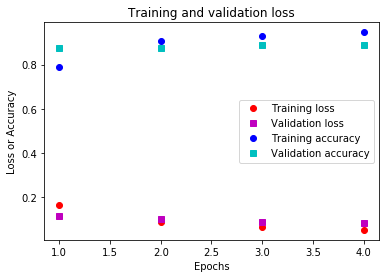

In [19]:
for test_number in range(number_of_tests):
    returned_dict = create_train_and_evaluate_model(loss_function='mse')
    test_accuracies[example_number, test_number] = returned_dict['accuracy'] 
    training_times[example_number, test_number] = returned_dict['time']
example_number += 1
graph_loss_and_accuracy(returned_dict)

### Example 9
* number of epochs = 4
* number of hidden layers = 1
* nodes per hidden layer = 32
* loss function = binary crossentropy
* **activation function = hyperbolic tangent**

Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 453us/step - loss: 0.4816 - acc: 0.7977 - val_loss: 0.3518 - val_acc: 0.8769
Epoch 2/4
15000/15000 [==============================] - 4s 262us/step - loss: 0.2735 - acc: 0.9076 - val_loss: 0.2822 - val_acc: 0.8891
Epoch 3/4
15000/15000 [==============================] - 4s 261us/step - loss: 0.1914 - acc: 0.9361 - val_loss: 0.2889 - val_acc: 0.8813
Epoch 4/4
25000/25000 [==============================] - 6s 227us/step
Train on 15000 samples, validate on 10000 samples
Epoch 1/4
15000/15000 [==============================] - 7s 453us/step - loss: 0.4671 - acc: 0.8109 - val_loss: 0.3825 - val_acc: 0.8455
Epoch 2/4
15000/15000 [==============================] - 4s 273us/step - loss: 0.2726 - acc: 0.9078 - val_loss: 0.3028 - val_acc: 0.8774
Epoch 3/4
15000/15000 [==============================] - 4s 268us/step - loss: 0.1908 - acc: 0.9354 - val_loss: 0.2699 - val_acc: 0.8906
Epoch 4

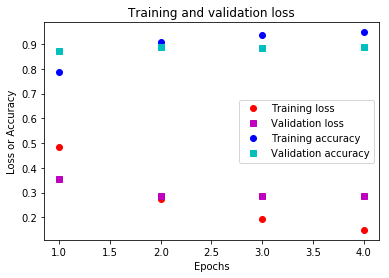

In [20]:
for test_number in range(number_of_tests):
    returned_dict = create_train_and_evaluate_model(activation_function='tanh')
    test_accuracies[example_number, test_number] = returned_dict['accuracy'] 
    training_times[example_number, test_number] = returned_dict['time']

example_number += 1
graph_loss_and_accuracy(returned_dict)

In [27]:
avg_training_times = np.mean(training_times[1:], axis=1)
avg_test_accuracies = np.mean(test_accuracies[1:], axis=1)

print(avg_training_times)
print(avg_test_accuracies)

[18.76719411 18.04768998 20.09093555 20.69133952 23.01454626 19.48761259
 19.80318583 19.96571349]
[0.878472 0.882416 0.87576  0.867336 0.850504 0.878184 0.870592 0.878056]


## Analysis

Below, I've plotted the average accuracies and training times from each of the previous examples I've included our original 20 epoch example to compare our averages to. It is the point in the bottom right corner. It took approximately four times as long to train and still has one of the worst accuracies. Let's get rid of the point so we can look closer at our other averages.

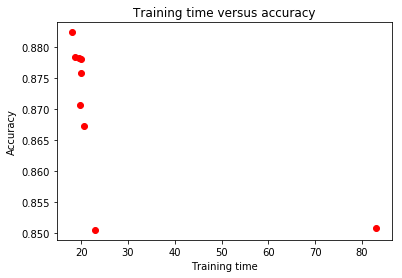

In [30]:
plt.clf()

plt.plot(training_times[0,0], test_accuracies[0,0], 'ro')
plt.plot(avg_training_times, avg_test_accuracies, 'ro')
plt.title('Training time versus accuracy')
plt.xlabel('Training time')
plt.ylabel('Accuracy')

plt.show()

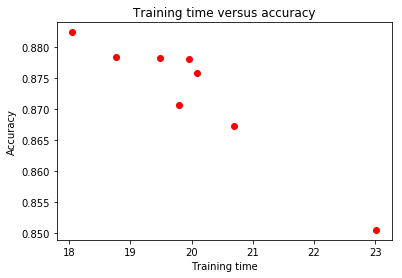

In [31]:
plt.clf()

plt.plot(avg_training_times, avg_test_accuracies, 'ro')
plt.title('Training time versus accuracy')
plt.xlabel('Training time')
plt.ylabel('Accuracy')

plt.show()

As our results show us there seems to be a negative correlation between training time and accuracy. Our proble is similar to the promblem we had in our first example. The two data points with the worst accuracy and most time taken are the examples that used 64 nodes per hidden layer and 32 nodes per hidden layer. The 64 nodes per hidden layer was the worse of the two. The reason these examples were over fit, because the more nodes used in hidden layers, the more detailed the boundry that the model describes between categories. This detailed model is bad at generalizing, and as such were thrown off by new inputs. To rub salt in the wound, these over fit models took longer to train because they have many times more computations to run. Our model with the shortest training time and best accuracy was actually the most generalized model we made. Our most efficient model only had one hidden layer of 16 nodes. 

The rest are easily clumped into a group, but let's see how different these models really are by using realtive difference.

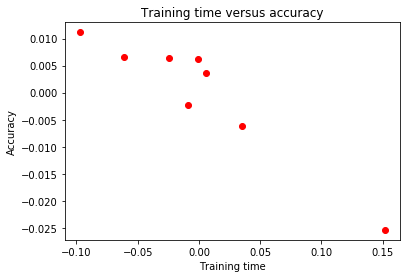

In [34]:
plt.clf()

#std deviation maybe?
avg_training_time = np.mean(avg_training_times)
avg_test_accuracy = np.mean(avg_test_accuracies)

relative_time_deviations = (avg_training_times - avg_training_time) / avg_training_time
relative_accuracy_deviations = (avg_test_accuracies - avg_test_accuracy) / avg_test_accuracy

plt.plot(relative_time_deviations, relative_accuracy_deviations, 'ro')
plt.title('Training time versus accuracy')
plt.xlabel('Training time')
plt.ylabel('Accuracy')

plt.show()

As we can see, our neural networks had very different training times ranging from 10 percent faster than average to 15 percent slower than average. However, our accuracies did not range nearly as much. Our best accuracy was one percent abouve average while our worst accuracy was 2.5 percent below average. While one percent may seem small, especially for something as inconsequential as our examples, one percent can have disasterous or tremendous results in other contexts.

Finally, it is important to remember that the general lesson of this experiment that over fitting can be time consuming and decrease accuracy, but it is also imprtant not to believe that every model will behave the same way when modified as they are in the examples. The same architecture could even yield different results using the same architecture with different training data.